In [59]:
import os
import numpy as np
import re
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats

from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

# Helper Functions to Parse Files


In [60]:
def load_liveInfo(directory):
    # FileFormat
    #
    # avgParticlesPerCell: 0.145314
    # cutoff: 3.000000
    # domainSizeX: 115.000000
    # domainSizeY: 215.000000
    # domainSizeZ: 145.000000
    # estimatedNumNeighborInteractions: 289010
    # maxParticlesPerCell: 26
    # minParticlesPerCell: 0
    # numCells: 137592
    # numEmptyCells: 131716
    # numHaloParticles: 0
    # numParticles: 19994
    # particleSize: 128
    # particleSizeNeededByFunctor: 72
    # particlesPerBlurredCellStdDev: 0.359923
    # particlesPerCellStdDev: 0.018441
    # rebuildFrequency: 10
    # skin: 1.000000
    # threadCount: 12

    def parseText(text):
        data = {}
        for line in text.split("\n"):
            if len(line) > 0:
                key, value = line.split(":")
                data[key.strip()] = float(value.strip())
        return data

    with open(directory + "/live_info_0.txt", "r") as file:
        text = file.read()
        data = parseText(text)
        return data


def load_best_configs(directory):
    # LineFormat
    #
    # Configuration: {Container: $A$ , CellSizeFactor: $B$ , Traversal: $C$ , Load Estimator: $D$ , Data Layout: $E$ , Newton 3: $F$}

    def parseText(text):
        rankings = []
        regex = r"Configuration: {Container: (.*) , CellSizeFactor: (.*) , Traversal: (.*) , Load Estimator: (.*) , Data Layout: (.*) , Newton 3: (.*)}"

        for line in text.split("\n"):
            match = re.search(regex, line)
            if match:
                data = {
                    "Container": match.group(1),
                    "CellSizeFactor": float(match.group(2)),
                    "Traversal": match.group(3),
                    "Load Estimator": match.group(4),
                    "Data Layout": match.group(5),
                    "Newton 3": match.group(6),
                }
                rankings.append(data)

        return rankings

    with open(directory + "/best_configs_0.txt", "r") as file:
        text = file.read()
        data = parseText(text)
        return data

# Load Data from Folders


In [61]:
dataSet = {
    "src_name": [],
    # input
    "avgParticlesPerCell": [],
    "cutoff": [],
    "domainSizeX": [],
    "domainSizeY": [],
    "domainSizeZ": [],
    "estimatedNumNeighborInteractions": [],
    "maxParticlesPerCell": [],
    "minParticlesPerCell": [],
    "numCells": [],
    "numEmptyCells": [],
    "numHaloParticles": [],
    "numParticles": [],
    "particleSize": [],
    "particleSizeNeededByFunctor": [],
    "particlesPerBlurredCellStdDev": [],
    "particlesPerCellStdDev": [],
    "rebuildFrequency": [],
    "skin": [],
    "threadCount": [],
    "ranking": [],
    # output
    "Container": [],
    "CellSizeFactor": [],
    "Traversal": [],
    "Load Estimator": [],
    "Data Layout": [],
    "Newton 3": [],
}

directories = []
for root, dirs, files in os.walk("./data/"):
    for name in dirs:
        directories.append(os.path.join(root, name))


# Always load the top 3 configurations to get more training data
TOP_K_CONFIGS = 3

for directory in directories:
    liveinfo = load_liveInfo(directory)
    best_config = load_best_configs(directory)

    for i, config in enumerate(best_config[:TOP_K_CONFIGS]):
        dataSet["ranking"].append(i)
        dataSet["src_name"].append(directory)
        for key in config:
            dataSet[key].append(config[key])

        for key in liveinfo:
            dataSet[key].append(liveinfo[key])

df = pd.DataFrame(dataSet)

# Define Interesting Data to observe


In [62]:
inputs = [
    "avgParticlesPerCell",
    # "cutoff",
    # "domainSizeX",
    # "domainSizeY",
    # "domainSizeZ",
    # "estimatedNumNeighborInteractions",
    "maxParticlesPerCell",
    # "minParticlesPerCell",
    "numCells",
    # "numEmptyCells",
    # "numHaloParticles",
    "numParticles",
    # "particleSize",
    # "particleSizeNeededByFunctor",
    # "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    # "rebuildFrequency",
    # "skin",
    # "threadCount",
    # "ranking"
]

outputs = [
    "Container",
    # "CellSizeFactor",
    "Traversal",
    # "Load Estimator",
    "Data Layout",
    "Newton 3",
]

# Filter Data / Outliers


In [63]:
# Remove any rows where colum lies outside 2 standard deviations
df = df[(np.abs(stats.zscore(df[inputs])) < 2).all(axis=1)]

# Remove any rows where the outcome occures less than 5% of the time
df = df[(df[outputs].apply(lambda x: x.map(
    x.value_counts(normalize=True)) > 0.03).all(axis=1))]

# save to csv
df.to_csv("cleaned.csv", index=False)

X, y = df[inputs], df[outputs]

# Final Data


In [64]:
pd.concat([X, y], axis=1)

,avgParticlesPerCell,maxParticlesPerCell,numCells,numParticles,particlesPerCellStdDev,Container,Traversal,Data Layout,Newton 3
0,0.141963,11.0,137592.0,19533.0,0.011052,VerletListsCells,vlc_c01,AoS,disabled
2,0.141963,11.0,137592.0,19533.0,0.011052,VerletLists,vl_list_iteration,AoS,disabled
3,1.680961,13.0,18772.0,31555.0,0.006755,VerletListsCells,vlc_c18,AoS,disabled
4,1.680961,13.0,18772.0,31555.0,0.006755,VerletListsCells,vlc_c18,AoS,enabled
5,1.680961,13.0,18772.0,31555.0,0.006755,VerletListsCells,vlc_sliced_c02,AoS,enabled
...,...,...,...,...,...,...,...,...,...
227,0.217508,1.0,42849.0,9320.0,0.009163,VerletClusterLists,vcl_c01_balanced,SoA,disabled
228,8.163265,28.0,147.0,1200.0,0.081258,LinkedCells,lc_c08,SoA,enabled
231,0.081417,2.0,4913.0,400.0,0.050462,VerletClusterLists,vcl_cluster_iteration,SoA,disabled
232,0.081417,2.0,4913.0,400.0,0.050462,VerletClusterLists,vcl_cluster_iteration,AoS,disabled


# Make some plots about the data


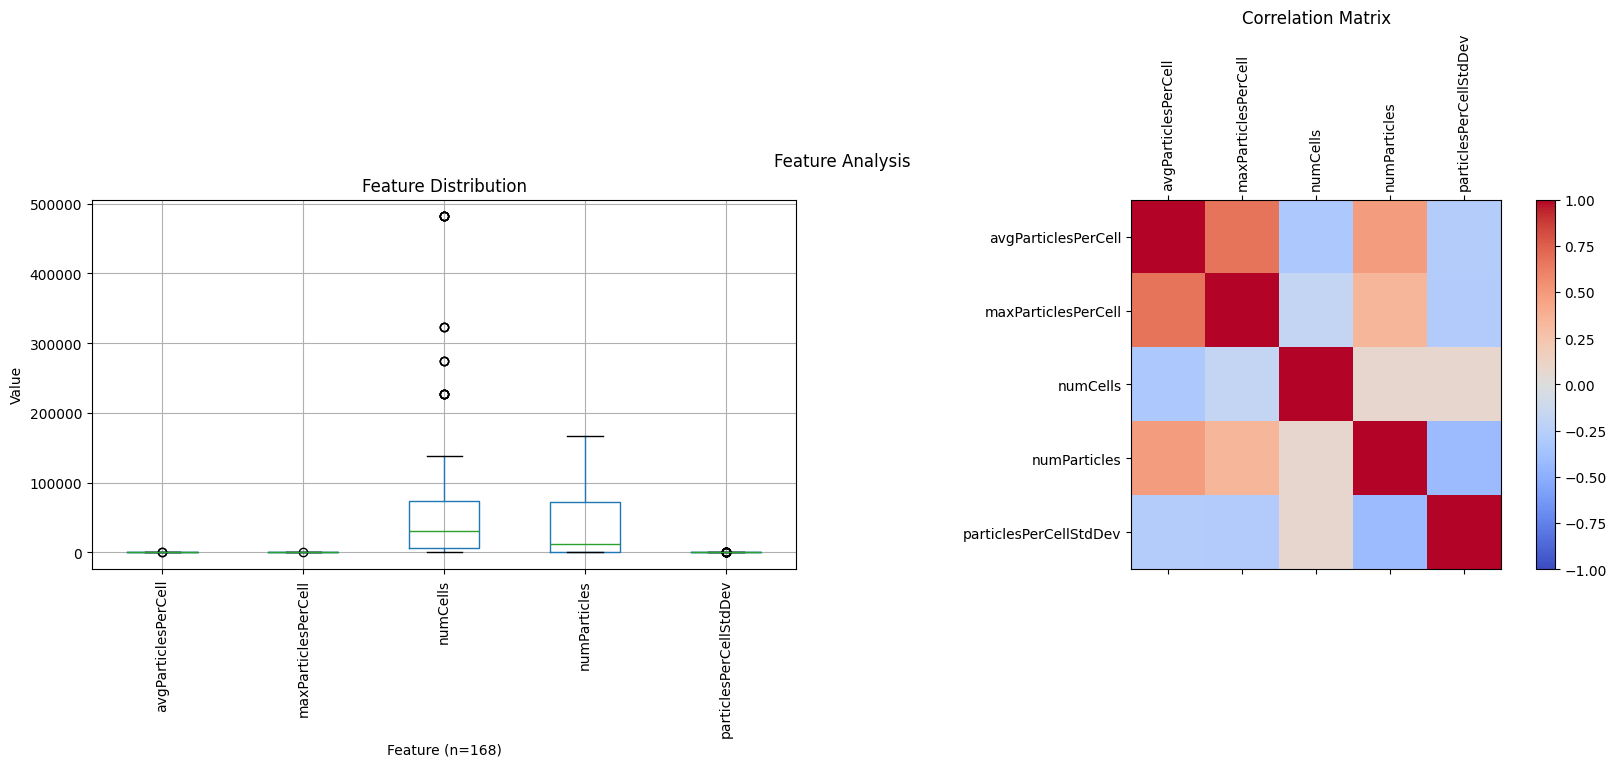

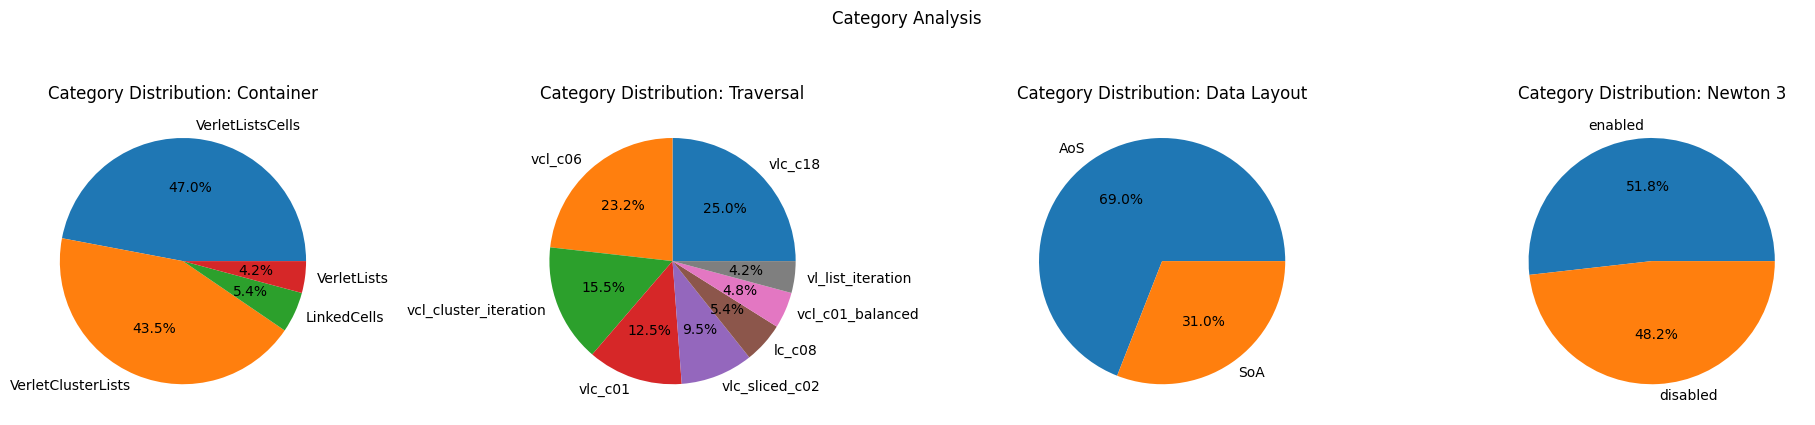

In [65]:
# Row 1
fig, ax1 = plt.subplots(1, 2)
fig.suptitle("Feature Analysis")
fig.set_figwidth(20)

# Axis 1 Boxplot for each feature

boxplot = X.boxplot(ax=ax1[0], showfliers=True)
ax1[0].set_title("Feature Distribution")
ax1[0].set_ylabel("Value")
ax1[0].set_xlabel(f"Feature (n={X.shape[0]})")
ax1[0].set_xticklabels(X.columns, rotation=90)

# Correlation Matrix
corr = X.corr()
cax = ax1[1].matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ax1[1].set_xticks(range(len(X.columns)))
ax1[1].set_yticks(range(len(X.columns)))
ax1[1].set_xticklabels(X.columns, rotation=90)
ax1[1].set_yticklabels(X.columns)
ax1[1].set_title("Correlation Matrix")

# Row 2
fig, ax1 = plt.subplots(1, len(y.columns))
fig.suptitle("Category Analysis")
fig.set_figwidth(20)
fig.tight_layout(pad=3.0)
for i, col in enumerate(y.columns):
    y_count = y[col].value_counts()
    ax1[i].pie(y_count, labels=y_count.index, autopct='%1.1f%%')
    ax1[i].set_title(f"Category Distribution: {col}")

# Helper Functions to make plots


In [66]:
def scatter_2d(df, x_name, y_name, label_name, filter=None, topK=TOP_K_CONFIGS):
    fig = plt.figure()
    fig.suptitle(f"2D Scatter Plot: {x_name} vs {y_name} for {label_name}")
    ax = fig.add_subplot(111)

    df_filtered = df[df["ranking"] < topK]

    x = df_filtered[x_name]
    y = df_filtered[y_name]
    labels = df_filtered[label_name]

    markers = ['o', 'x', 's', 'v', '^']
    for i, c in enumerate(np.unique(labels)):
        if filter is None or c in filter:
            ax.scatter(x[labels == c], y[labels == c],
                       label=c, marker=markers[i % len(markers)])

    for t in [*ax.get_xticklabels(), *ax.get_yticklabels()]:
        t.set_rotation(45)

    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.legend()


def scatter_3d(df, x_name, y_name, z_name, label_name, filter=None, topK=TOP_K_CONFIGS):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    fig.suptitle(f"3D Scatter Plot: {x_name} vs {
                 y_name} vs {z_name} for {label_name}")

    df_filtered = df[df["ranking"] < topK]

    x = df_filtered[x_name]
    y = df_filtered[y_name]
    z = df_filtered[z_name]
    labels = df_filtered[label_name]

    markers = ['o', 'x', 's', 'v', '^']
    for i, c in enumerate(np.unique(labels)):
        if filter is None or c in filter:
            ax.scatter(x[labels == c], y[labels == c], z[labels == c],
                       label=c, marker=markers[i % len(markers)])

    for t in [*ax.get_xticklabels(), *ax.get_yticklabels(), *ax.get_zticklabels()]:
        t.set_rotation(45)

    # format ticklabes
    ax.ticklabel_format(axis='both', style='sci', scilimits=(-4, 2))

    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_zlabel(z_name)
    ax.legend()

# Automatic Rule Learning


In [67]:
class Condition:
    def __init__(self, feature, operator, threshold):
        self.feature = feature
        self.operator = operator
        self.threshold = threshold

    def __str__(self):
        return f"({self.feature} {self.operator} {self.threshold})"


class Rule:
    # Condions are combined with AND, while the elements in a condition are combined with OR
    def __init__(self, conditions: list[list[Condition]], prediction):
        self.conditions = conditions
        self.prediction = prediction

    def __str__(self):
        return f"if {' && '.join(['(' + ' || '.join([str(c) for c in cond]) + ')' for cond in self.conditions])} then {self.prediction}"

# Decision Tree


In [68]:
def train_decision_tree(df, inputs, outputs) -> tuple[DecisionTreeClassifier, float, preprocessing.LabelEncoder]:
    labels = df[outputs]
    pre = preprocessing.LabelEncoder()
    labels_enc = pre.fit_transform(labels)

    model = DecisionTreeClassifier(
        random_state=1, ccp_alpha=0.01, max_depth=len(inputs))

    # create test
    X_train, X_test, y_train, y_test = train_test_split(
        df[inputs], labels_enc, test_size=0.2, random_state=1)

    model.fit(X_train, y_train)

    score = model.score(df[inputs], labels_enc)

    return model, score, pre


def extract_rules_from_decision_tree(tree, feature_names, class_names) -> list[Rule]:
    tree_ = tree.tree_

    paths = []
    path = []

    def recurse(node, path, paths):

        if tree_.feature[node] != -2:
            name = feature_names[tree_.feature[node]]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1.append(Condition(name, "<=", np.round(threshold, 3)))
            recurse(tree_.children_left[node], p1, paths)
            p2.append(Condition(name, ">", np.round(threshold, 3)))
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]

    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]

    rules = []
    for path in paths:
        conditions = list(map(lambda x: [x], path[:-1]))

        classes = path[-1][0][0]
        l = np.argmax(classes)
        results = class_names[l]

        rules.append(Rule(conditions, results))

    return rules

# Helper Functions to learn and plot Decision Trees


In [69]:
def find_rules2d(df, x_name, y_name, label_name, filter=None, topK=TOP_K_CONFIGS):
    df_filtered = df[df["ranking"] < topK]

    model, score, pre = train_decision_tree(
        df_filtered, [x_name, y_name], label_name)

    if (score < 0.8):
        return

    rules = extract_rules_from_decision_tree(
        model, [x_name, y_name], pre.classes_)

    # Make plots

    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(16)

    xx, yy = np.meshgrid(np.linspace(df_filtered[x_name].min(), df_filtered[x_name].max(), 100),
                         np.linspace(df_filtered[y_name].min(), df_filtered[y_name].max(), 100))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax[0].contourf(xx, yy, Z, alpha=0.4)

    markers = ['o', 'x', 's', 'v', '^']
    for i, c in enumerate(np.unique(pre.classes_)):
        if filter is None or c in filter:
            ax[0].scatter(df_filtered[x_name][df_filtered[label_name] == c], df_filtered[y_name][df_filtered[label_name] == c],
                          label=c, marker=markers[i % len(markers)])

    ax[0].set_xlabel(x_name)
    ax[0].set_ylabel(y_name)
    ax[0].set_title(f"Decision Tree: {x_name} vs {
                    y_name} for {label_name} (Score: {score})")
    ax[0].legend()

    plot_tree(model, ax=ax[1], feature_names=[
              x_name, y_name], class_names=pre.classes_)

    return rules


def find_rules3d(df, x_name, y_name, z_name, label_name, filter=None, topK=TOP_K_CONFIGS):
    df_filtered = df[df["ranking"] < topK]

    model, score, pre = train_decision_tree(
        df_filtered, [x_name, y_name, z_name], label_name)

    if (score < 0.8):
        return

    rules = extract_rules_from_decision_tree(
        model, [x_name, y_name, z_name], pre.classes_)

    # Make plots

    fig = plt.figure()
    fig.set_figwidth(16)
    ax = fig.add_subplot(121, projection='3d')

    markers = ['o', 'x', 's', 'v', '^']
    for i, c in enumerate(np.unique(pre.classes_)):
        if filter is None or c in filter:
            ax.scatter(df_filtered[x_name][df_filtered[label_name] == c], df_filtered[y_name][df_filtered[label_name] == c],
                       df_filtered[z_name][df_filtered[label_name] == c], label=c, marker=markers[i % len(markers)])

    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_zlabel(z_name)
    ax.legend()

    fig.suptitle(f"Decision Tree: {x_name} vs {y_name} vs {
                 z_name} for {label_name} (Score: {score})")

    ax = fig.add_subplot(122)

    plot_tree(model, ax=ax, feature_names=[
        x_name, y_name, z_name], class_names=pre.classes_)

    return rules

# Create a bunch of plots to find correlations


/home/manuel/miniconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/manuel/miniconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/manuel/miniconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/manuel/miniconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/manuel/miniconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/manu

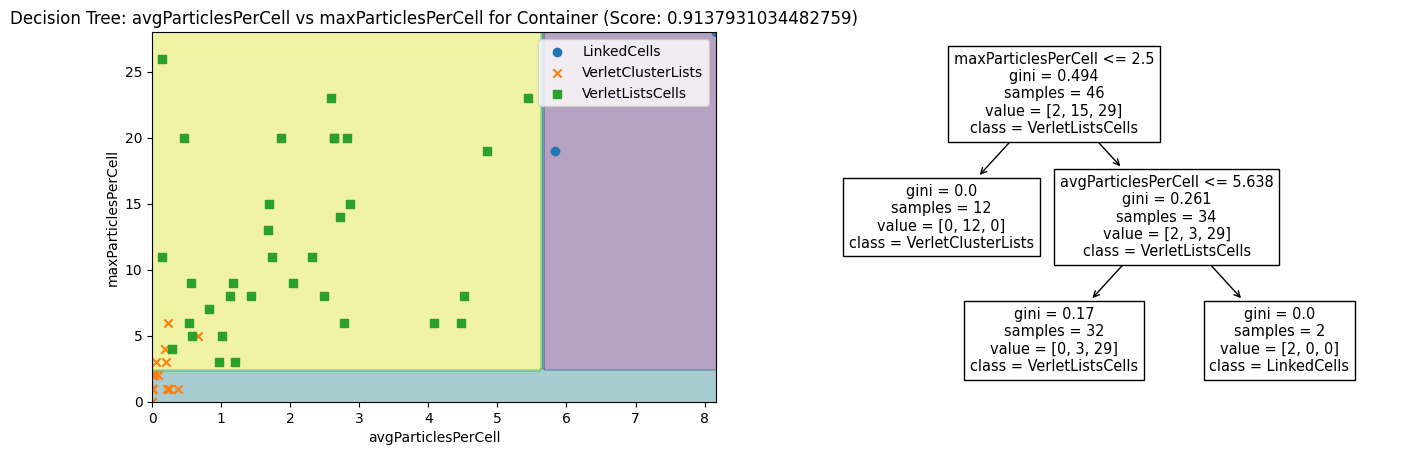

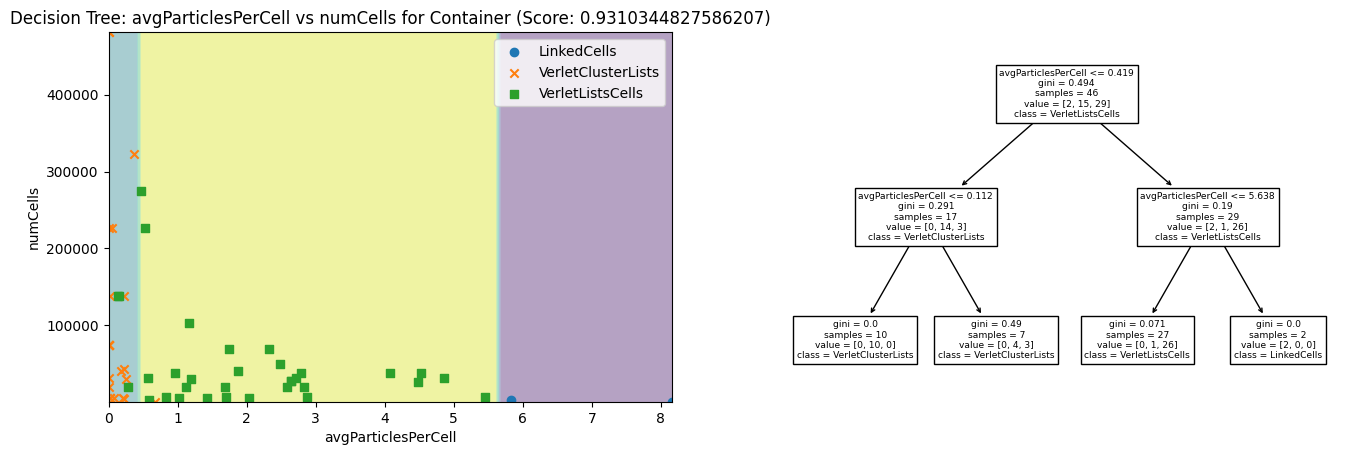

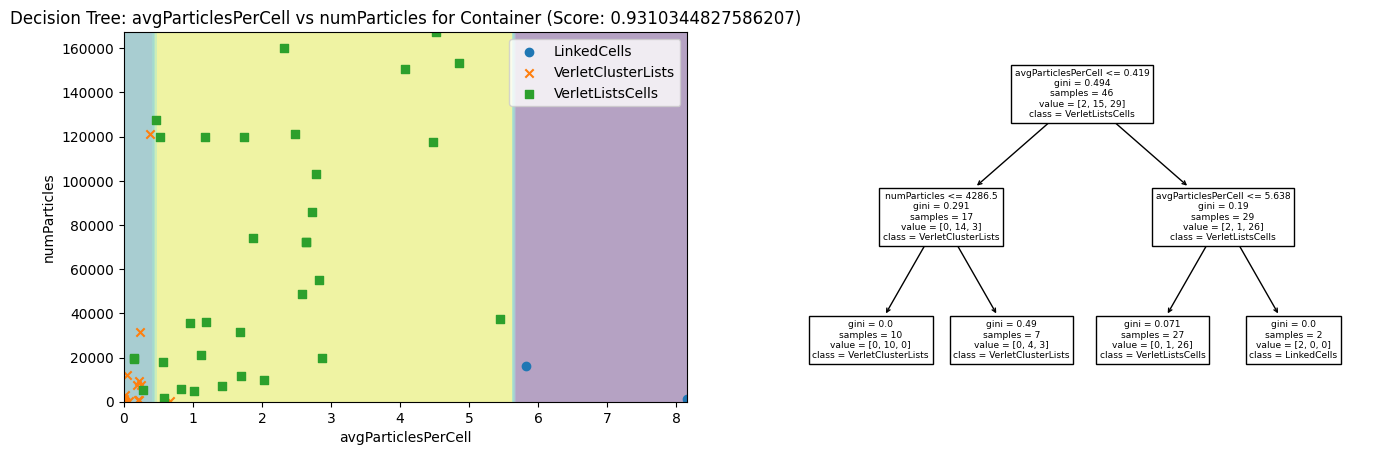

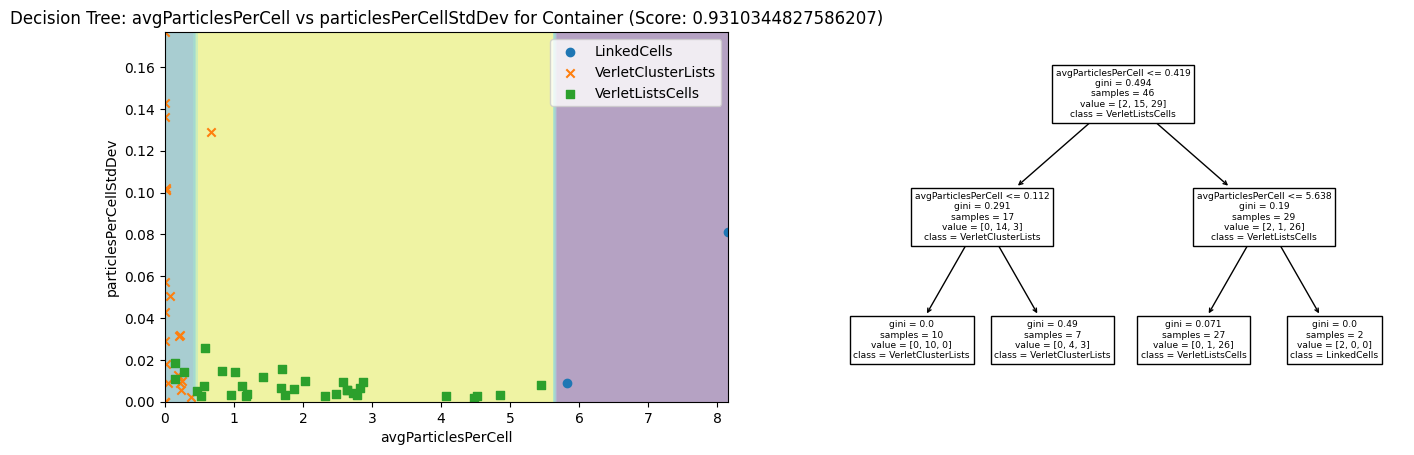

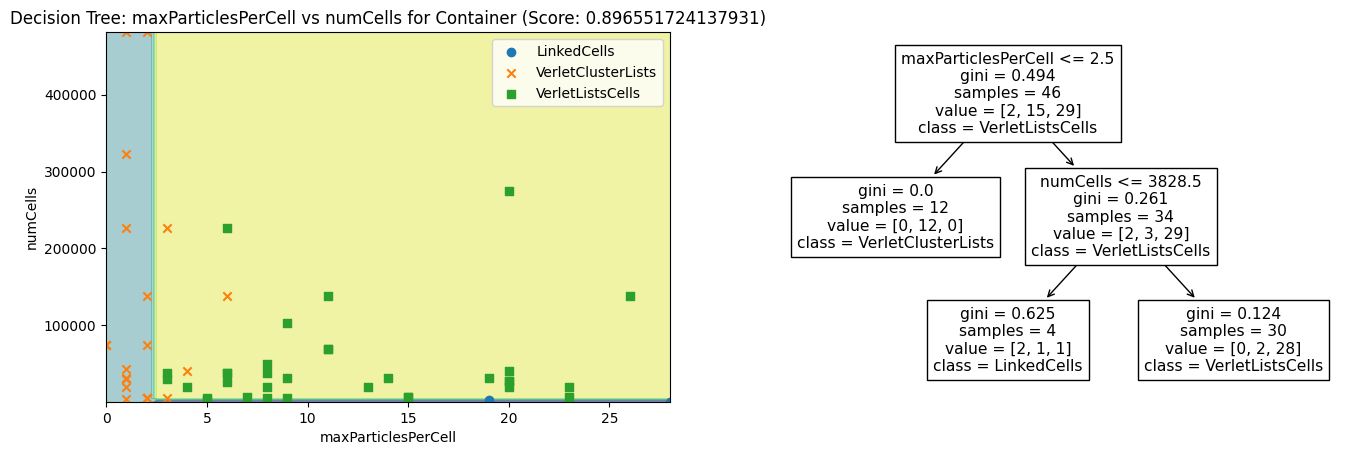

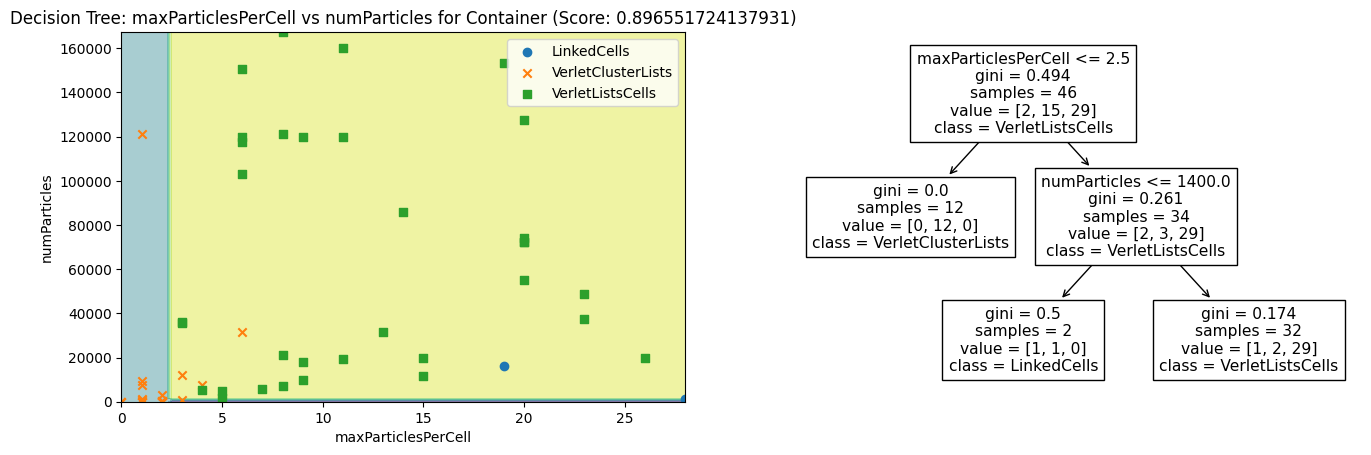

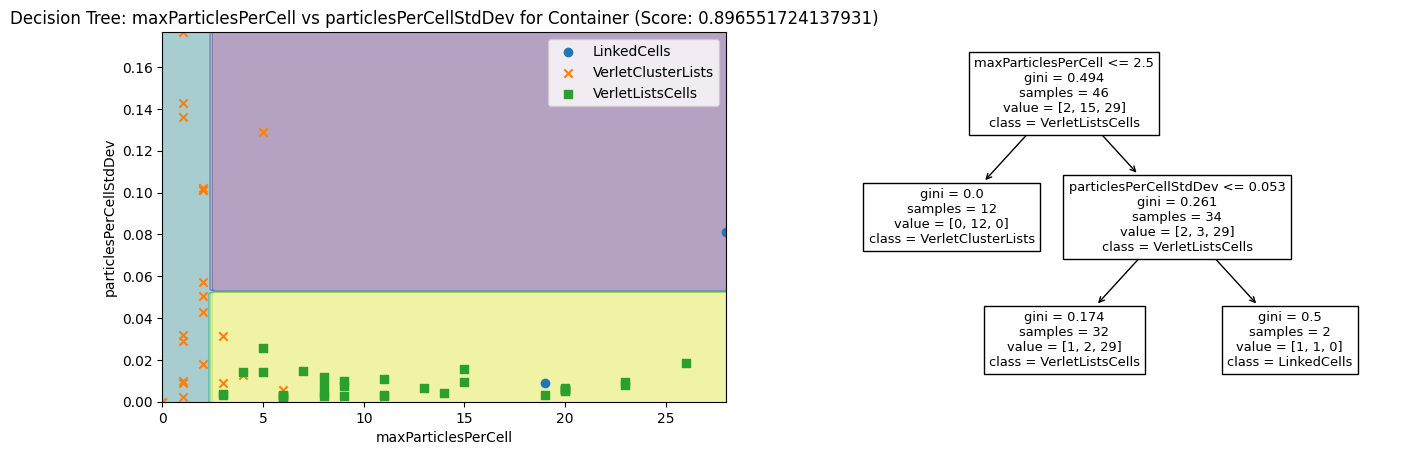

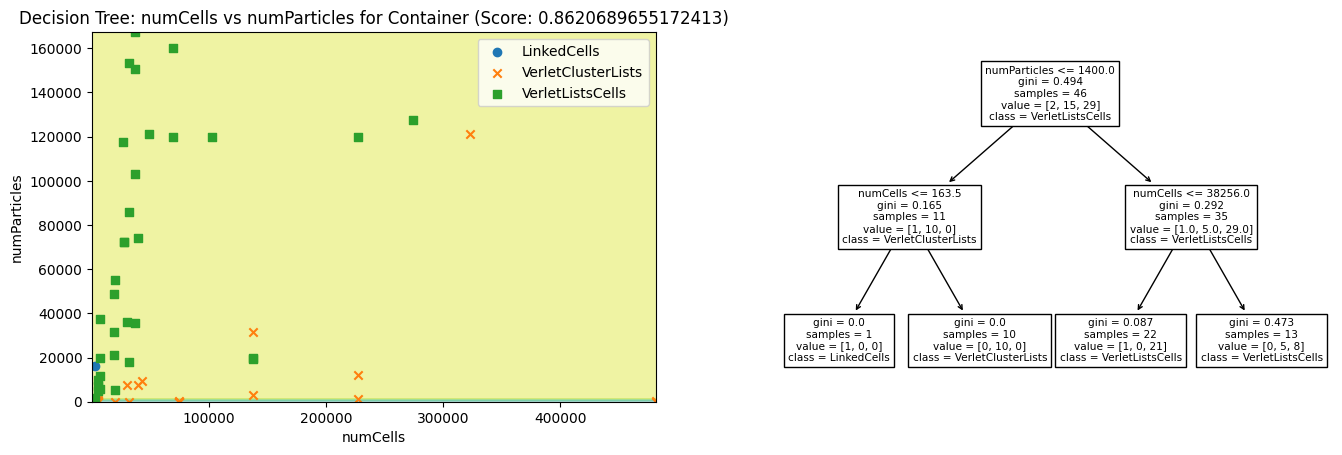

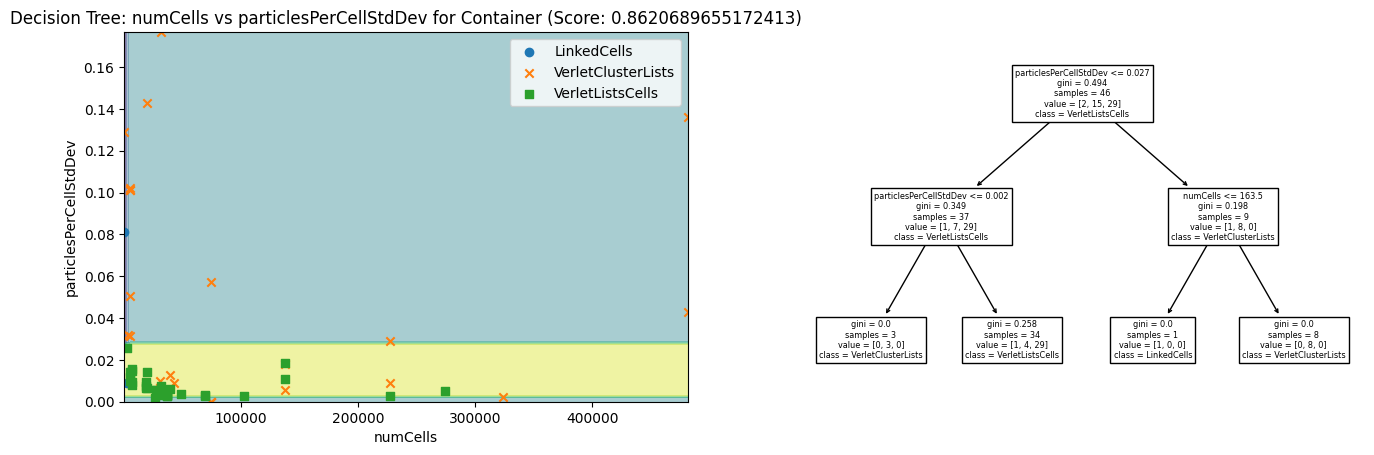

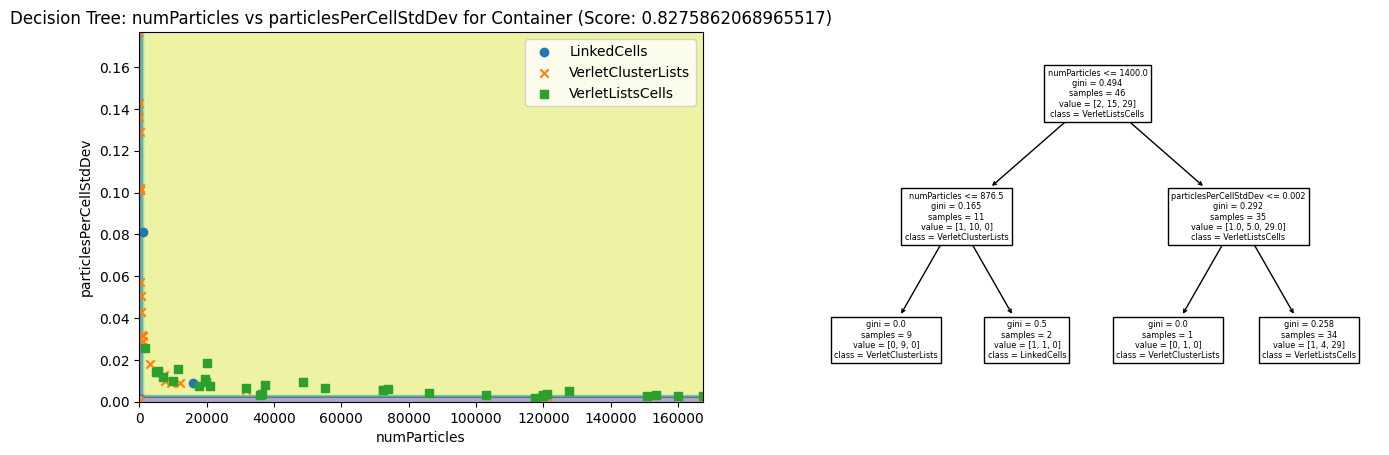

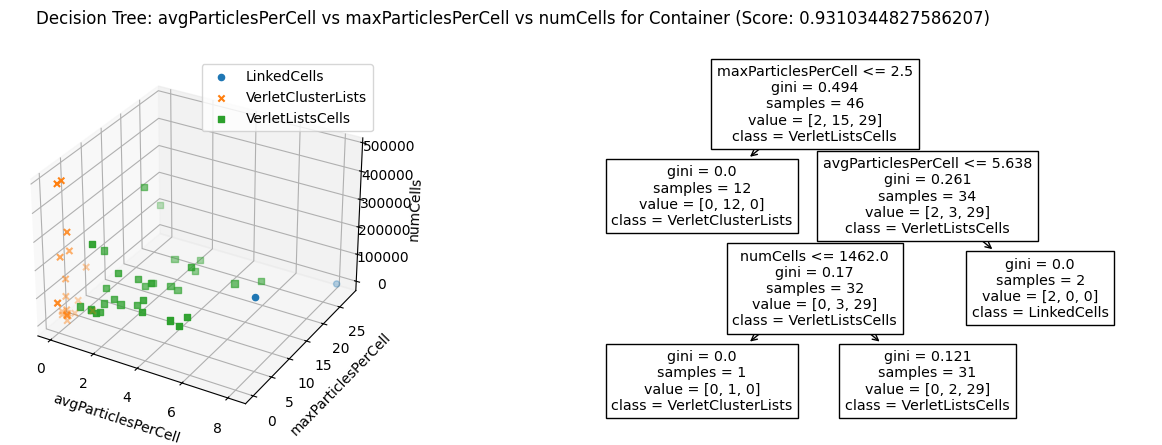

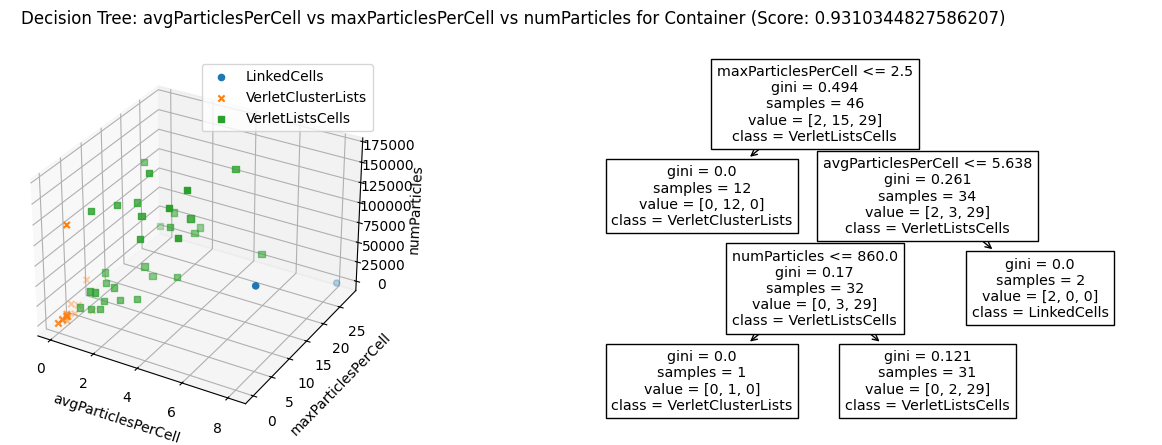

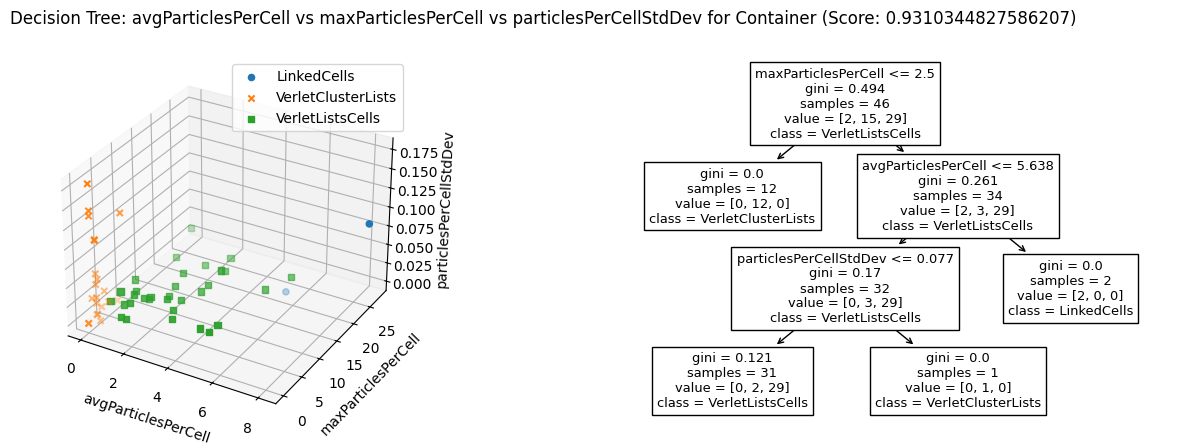

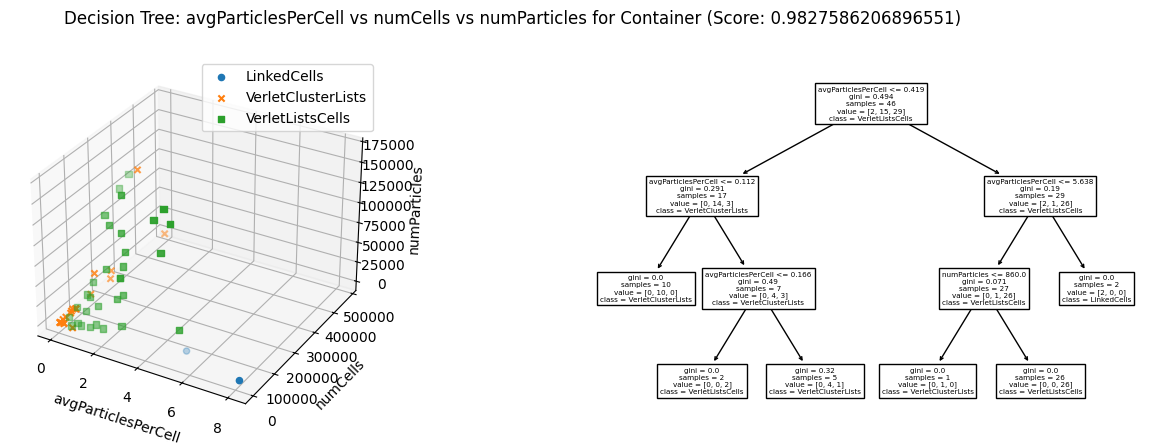

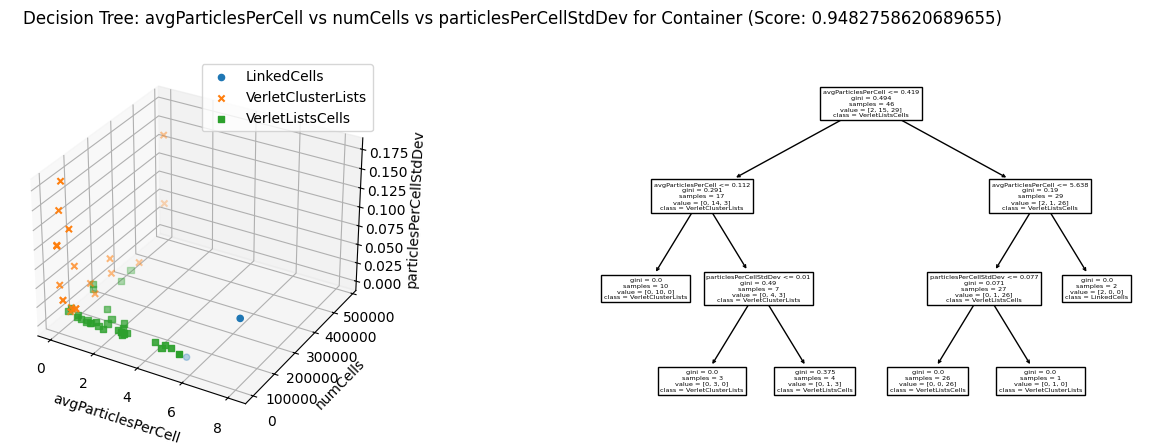

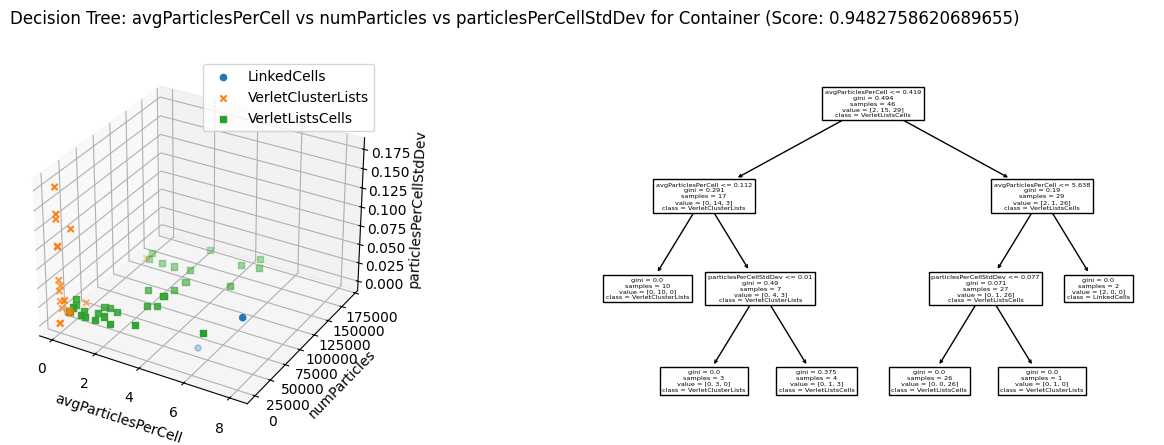

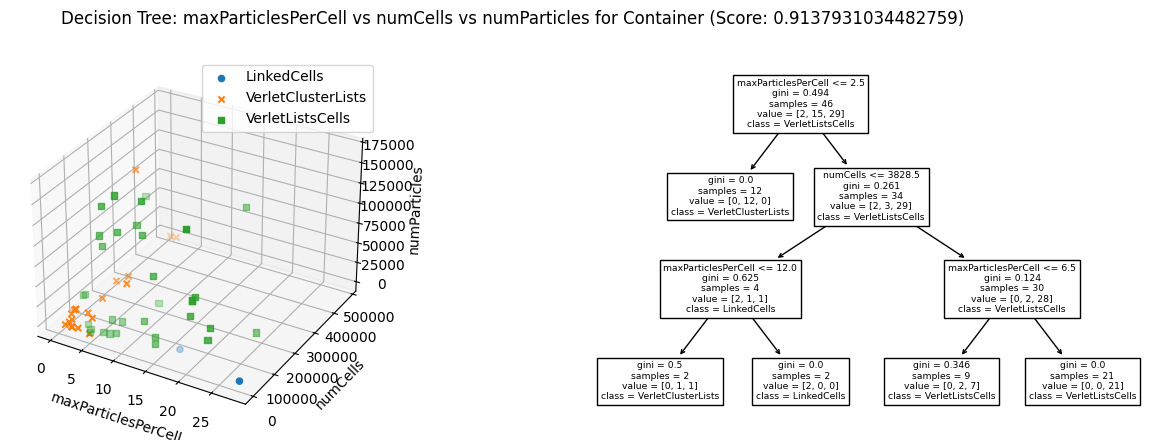

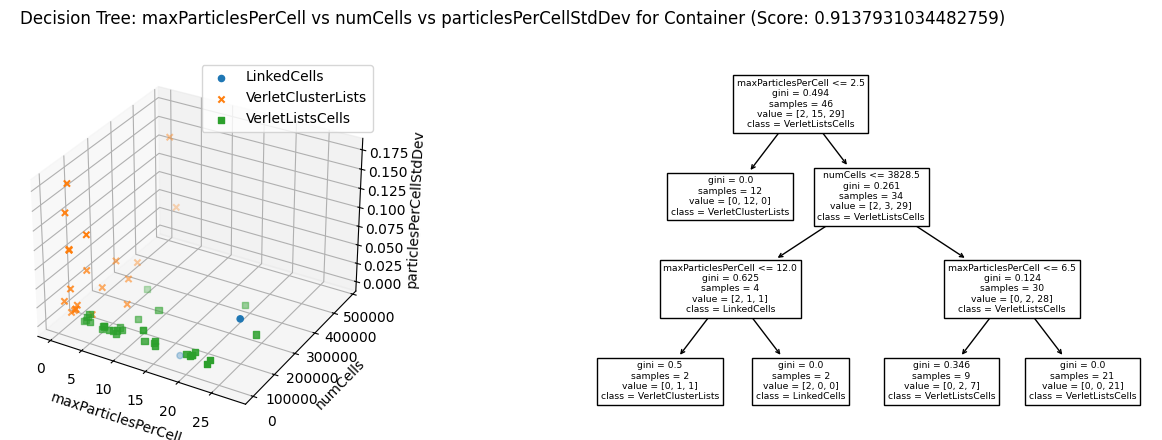

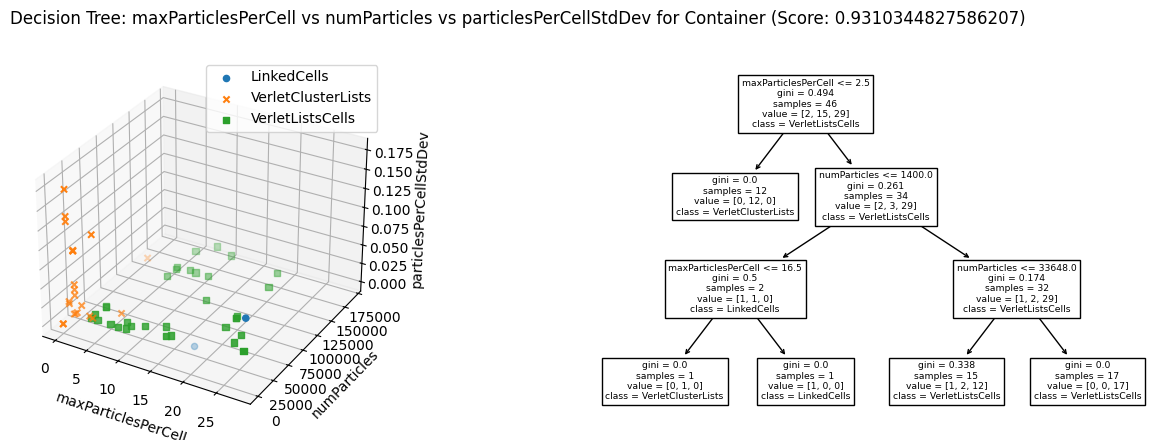

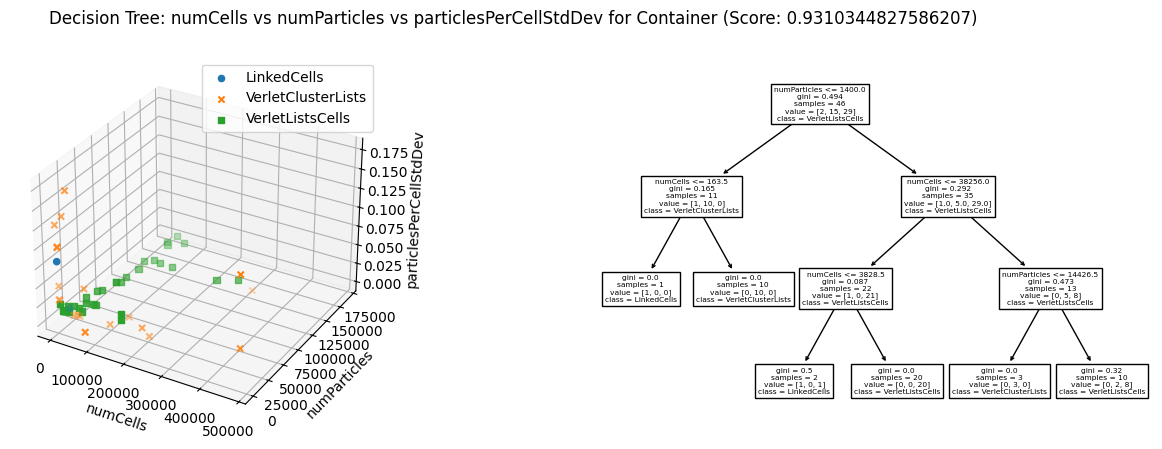

In [70]:
import itertools

label = y.columns[0]

auto_rules = []

for x in itertools.combinations(X.columns, 2):
    rules = find_rules2d(df, x[0], x[1], label, topK=1)
    auto_rules.extend(rules)


for x in itertools.combinations(X.columns, 3):
    rules = find_rules3d(df, x[0], x[1], x[2], label, topK=1)
    auto_rules.extend(rules)

# Membership Functions Function


In [71]:
class Gaussian:
    def __init__(self, axis, name, mu, sig):
        self.axis = axis
        self.name = name
        self.mu = mu
        self.sig = sig

    def __call__(self, x):
        return np.exp(-np.power(x - self.mu, 2.) / (2 * np.power(self.sig, 2.)))

    def __repr__(self):
        return f"{self.name}: Gaussian({self.mu:.2f}, {self.sig:.2f})"

    def peak(self):
        return self.mu


class Sigmoid:
    def __init__(self, axis, name, a, b):
        self.axis = axis
        self.name = name
        self.a = a
        self.b = b

    def __call__(self, x):
        return 1 / (1 + np.exp(-self.a * (x - self.b)))

    def __repr__(self):
        return f"{self.name}: Sigmoid({self.a:.2f}, {self.b:.2f})"

    def peak(self):
        return np.inf if self.a > 0 else -np.inf

# Create Plots for Membership Functions


Each Interval between two boundaries of the Decision Tree becomes a Membership Function.


In [72]:
dimensionsBoundariesAll: dict[str, list[float]] = {}

for rule in auto_rules:
    for andCond in rule.conditions:
        for condition in andCond:
            feature = condition.feature
            threshold = condition.threshold

            if feature not in dimensionsBoundariesAll:
                dimensionsBoundariesAll[feature] = [-np.inf, np.inf]
            else:
                dimensionsBoundariesAll[feature].append(threshold)

# sort and remove duplicates
for feature in dimensionsBoundariesAll:
    dimensionsBoundariesAll[feature] = sorted(
        list(set(dimensionsBoundariesAll[feature])))


# Clean up boundaries, remove close values

dimensionsBoundaries: dict[str, list[float]] = {}
for feature in dimensionsBoundariesAll:
    boundaries = sorted(dimensionsBoundariesAll[feature])

    average_diff = np.mean(
        list(filter(lambda x: x != np.inf, np.diff(boundaries))))

    new_boundaries = [boundaries[0]]
    for i in range(1, len(boundaries)):
        diff = boundaries[i] - new_boundaries[-1]
        if diff < 0.2 * average_diff:
            continue
        new_boundaries.append(boundaries[i])

    dimensionsBoundaries[feature] = new_boundaries

# Print out the cleaned
for feature in dimensionsBoundaries:
    print(f"{feature}: {dimensionsBoundariesAll[feature]}")
    print(f"{feature}: {dimensionsBoundaries[feature]}")
    print()

maxParticlesPerCell: [-inf, 2.5, 6.5, 12.0, 16.5, inf]
maxParticlesPerCell: [-inf, 2.5, 6.5, 12.0, 16.5, inf]

avgParticlesPerCell: [-inf, 0.112, 0.166, 0.419, 5.638, inf]
avgParticlesPerCell: [-inf, 0.112, 5.638, inf]

numParticles: [-inf, 860.0, 876.5, 1400.0, 4286.5, 14426.5, 33648.0, inf]
numParticles: [-inf, 860.0, 4286.5, 14426.5, 33648.0, inf]

numCells: [-inf, 163.5, 1462.0, 3828.5, 38256.0, inf]
numCells: [-inf, 163.5, 3828.5, 38256.0, inf]

particlesPerCellStdDev: [-inf, 0.002, 0.01, 0.027, 0.053, 0.077, inf]
particlesPerCellStdDev: [-inf, 0.002, 0.01, 0.027, 0.053, 0.077, inf]



# Create Activation Functions


/tmp/ipykernel_147222/1315762347.py:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-self.a * (x - self.b)))


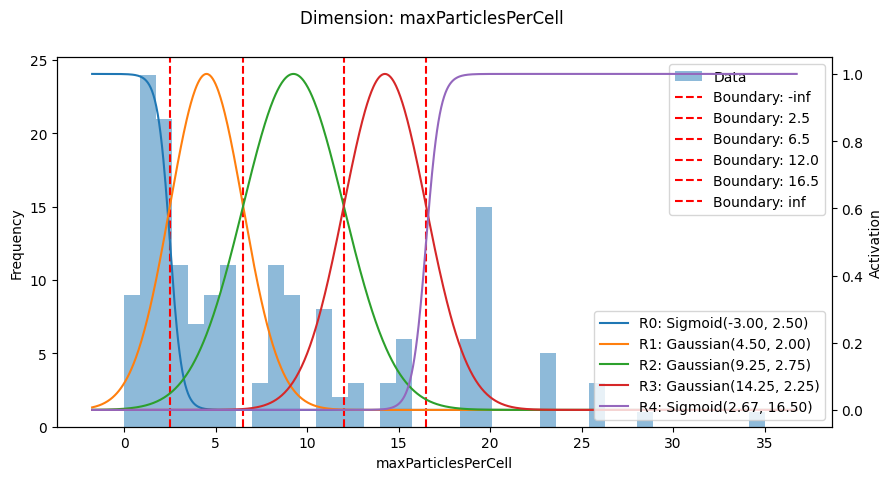

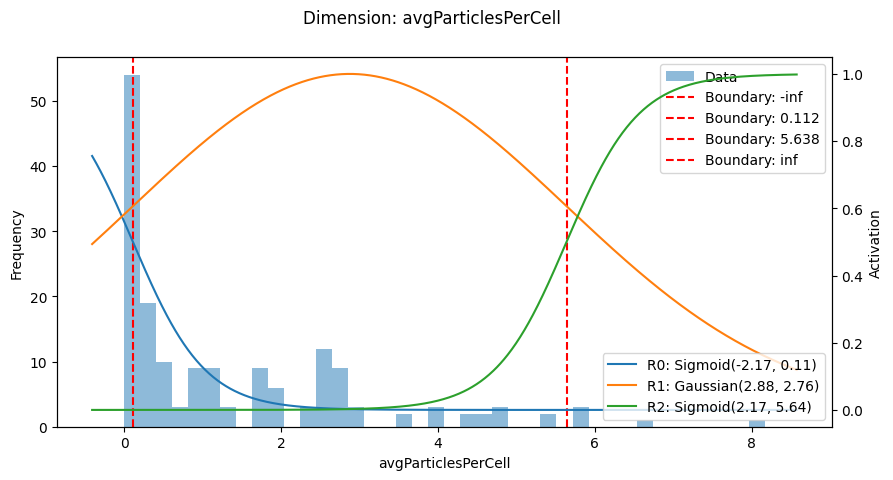

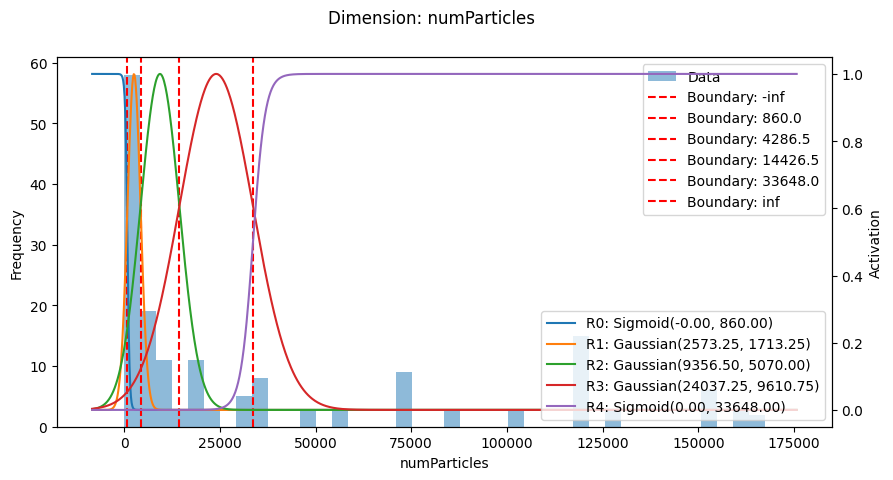

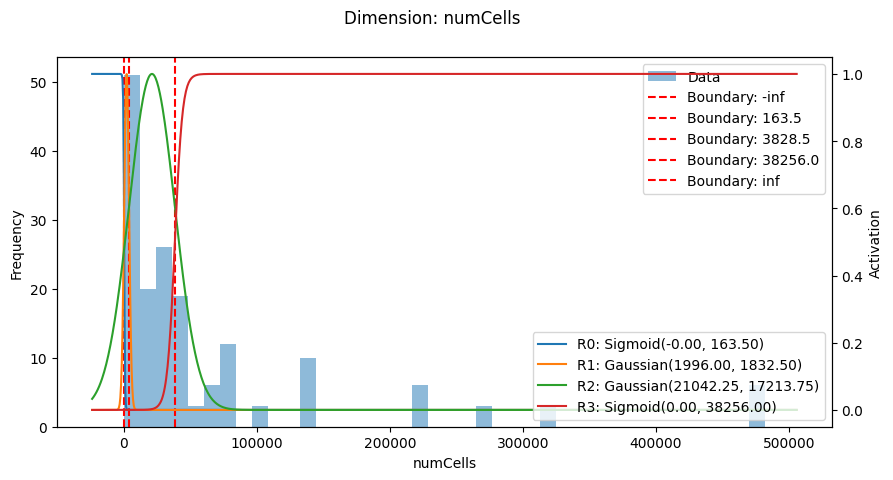

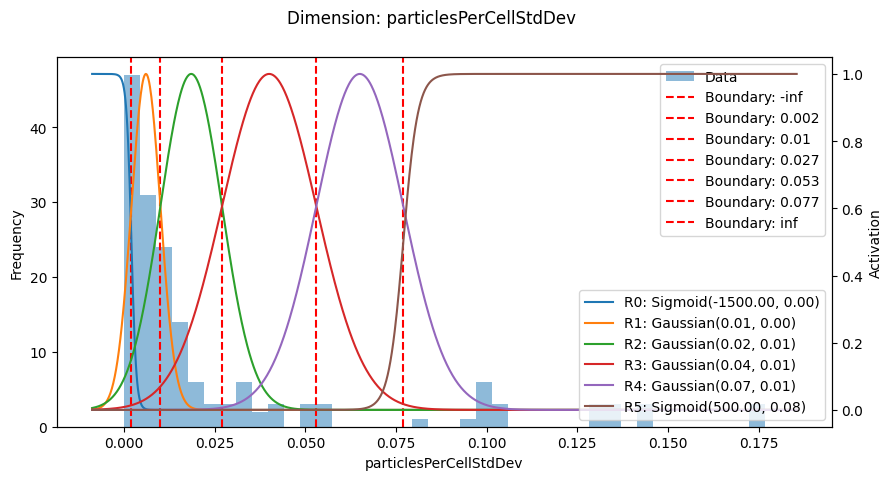

In [73]:
inputRangeMembershipFunctions: dict[str, list] = {}

for dim in dimensionsBoundaries:
    inputRangeMembershipFunctions[dim] = []

    boundaries = sorted(dimensionsBoundaries[dim])
    for i, (curr, next) in enumerate(zip(boundaries, boundaries[1:])):
        if (next-curr == np.inf):
            boundary = curr if curr != -np.inf else next

            neighbour_range = boundaries[i -
                                         1:i+1] if i > 0 else boundaries[i+1:i+3]

            std = (neighbour_range[1] - neighbour_range[0]) / 2
            if np.abs(std) == np.inf:
                std = (df[dim].max() - df[dim].min()) / 2

            flipped = -1 if curr == -np.inf else 1
            std *= flipped

            inputRangeMembershipFunctions[dim].append(
                Sigmoid(dim, f"R{i}", 6/std, boundary))
        else:
            mean = (curr + next) / 2
            std = (next - curr) / 2
            inputRangeMembershipFunctions[dim].append(
                Gaussian(dim, f"R{i}", mean, std))

    fig, ax1 = plt.subplots(1, 1)
    ax2 = ax1.twinx()

    fig.suptitle(f"Dimension: {dim}")
    fig.set_figwidth(10)

    ax1.hist(df[dim], bins=40, alpha=0.5, label="Data")

    for rule_range in sorted(dimensionsBoundaries[dim]):
        ax1.axvline(x=rule_range, color='r', linestyle='--',
                    label=f"Boundary: {rule_range}")

    min_x = df[dim].min()
    max_x = df[dim].max()
    x = np.linspace(min_x-0.05*(max_x-min_x), max_x+0.05*(max_x-min_x), 1000)

    for i, f in enumerate(inputRangeMembershipFunctions[dim]):
        ax2.plot(x, f(x), label=f)

    ax1.set_xlabel(dim)
    ax1.set_ylabel("Frequency")
    ax1.legend(loc='upper right')

    ax2.set_ylabel("Activation")
    ax2.legend(loc='lower right')

# Create Fuzzy Rules from Decision Tree Rules


Rules of the decision tree are mapped to Fuzzy Rules.

E.g if the Decision Tree Rule is: `If A > 5 then C` then the Fuzzy Rule is: `If {Or combination of [A == m for m in (List of all membership functions with mean > 5)]} then C`


In [74]:
fuzzy_rules = []
for rule in auto_rules:

    new_conditions = []
    for and_cond in rule.conditions:
        or_condition = []
        for condition in and_cond:
            feature = condition.feature
            operator = condition.operator
            threshold = condition.threshold

            applicable_functions = list(filter(
                lambda f: eval(f"{threshold} {operator} f.peak()"), inputRangeMembershipFunctions[feature]))

            if len(applicable_functions) == 0:
                continue

            for f in applicable_functions:
                or_condition.append(Condition(feature, "==", '"'+f.name+'"'))

        new_conditions.append(or_condition)

    new_rule = Rule(new_conditions, rule.prediction)

    fuzzy_rules.append(new_rule)

In [75]:
print(f"Number of Input Dimensions: {len(inputRangeMembershipFunctions)}")
print(f"Number of Activation Functions: {sum([len(inputRangeMembershipFunctions[dim]) for dim in inputRangeMembershipFunctions])}\n")

for axis in inputRangeMembershipFunctions:
    print(axis+":")
    for f in inputRangeMembershipFunctions[axis]:
        print("\t", f)
    print("")

Number of Input Dimensions: 5
Number of Activation Functions: 23

maxParticlesPerCell:
	 R0: Sigmoid(-3.00, 2.50)
	 R1: Gaussian(4.50, 2.00)
	 R2: Gaussian(9.25, 2.75)
	 R3: Gaussian(14.25, 2.25)
	 R4: Sigmoid(2.67, 16.50)

avgParticlesPerCell:
	 R0: Sigmoid(-2.17, 0.11)
	 R1: Gaussian(2.88, 2.76)
	 R2: Sigmoid(2.17, 5.64)

numParticles:
	 R0: Sigmoid(-0.00, 860.00)
	 R1: Gaussian(2573.25, 1713.25)
	 R2: Gaussian(9356.50, 5070.00)
	 R3: Gaussian(24037.25, 9610.75)
	 R4: Sigmoid(0.00, 33648.00)

numCells:
	 R0: Sigmoid(-0.00, 163.50)
	 R1: Gaussian(1996.00, 1832.50)
	 R2: Gaussian(21042.25, 17213.75)
	 R3: Sigmoid(0.00, 38256.00)

particlesPerCellStdDev:
	 R0: Sigmoid(-1500.00, 0.00)
	 R1: Gaussian(0.01, 0.00)
	 R2: Gaussian(0.02, 0.01)
	 R3: Gaussian(0.04, 0.01)
	 R4: Gaussian(0.07, 0.01)
	 R5: Sigmoid(500.00, 0.08)



In [76]:
print(f"Number of Automatic Fuzzy Rules: {len(fuzzy_rules)}\n")

for rule in fuzzy_rules:
    print(rule)

Number of Automatic Fuzzy Rules: 87

if ((maxParticlesPerCell == "R0")) && ((avgParticlesPerCell == "R2")) then VerletListsCells
if ((maxParticlesPerCell == "R1") || (maxParticlesPerCell == "R2") || (maxParticlesPerCell == "R3") || (maxParticlesPerCell == "R4")) then VerletClusterLists
if ((maxParticlesPerCell == "R0")) && ((avgParticlesPerCell == "R0") || (avgParticlesPerCell == "R1")) then LinkedCells
if ((avgParticlesPerCell == "R0")) && ((avgParticlesPerCell == "R2")) then VerletListsCells
if ((avgParticlesPerCell == "R1") || (avgParticlesPerCell == "R2")) && ((avgParticlesPerCell == "R1") || (avgParticlesPerCell == "R2")) then VerletClusterLists
if ((avgParticlesPerCell == "R1") || (avgParticlesPerCell == "R2")) && ((avgParticlesPerCell == "R0")) then VerletClusterLists
if ((avgParticlesPerCell == "R0")) && ((avgParticlesPerCell == "R0") || (avgParticlesPerCell == "R1")) then LinkedCells
if ((avgParticlesPerCell == "R0")) && ((avgParticlesPerCell == "R2")) then VerletListsCells
if